
--- [DEBUG] Checking CSV Columns ---
Columns found in '../dataset/franka_research3/fr3_matched_joint_angle.csv':
['image_path', 'image_timestamp', 'robot_timestamp', 'time_difference_s', 'timestamp', 'position_fr3_joint1', 'velocity_fr3_joint1', 'effort_fr3_joint1', 'position_fr3_joint2', 'velocity_fr3_joint2', 'effort_fr3_joint2', 'position_fr3_joint3', 'velocity_fr3_joint3', 'effort_fr3_joint3', 'position_fr3_joint4', 'velocity_fr3_joint4', 'effort_fr3_joint4', 'position_fr3_joint5', 'velocity_fr3_joint5', 'effort_fr3_joint5', 'position_fr3_joint6', 'velocity_fr3_joint6', 'effort_fr3_joint6', 'position_fr3_joint7', 'velocity_fr3_joint7', 'effort_fr3_joint7', 'position_fr3_finger_joint1', 'velocity_fr3_finger_joint1', 'effort_fr3_finger_joint1', 'position_fr3_finger_joint2', 'velocity_fr3_finger_joint2', 'effort_fr3_finger_joint2']
-------------------------------------

--- Finding a random representative image for each POSE/view/cam combination ---
Searching for pose: 'pose1'
  ✅ Fo

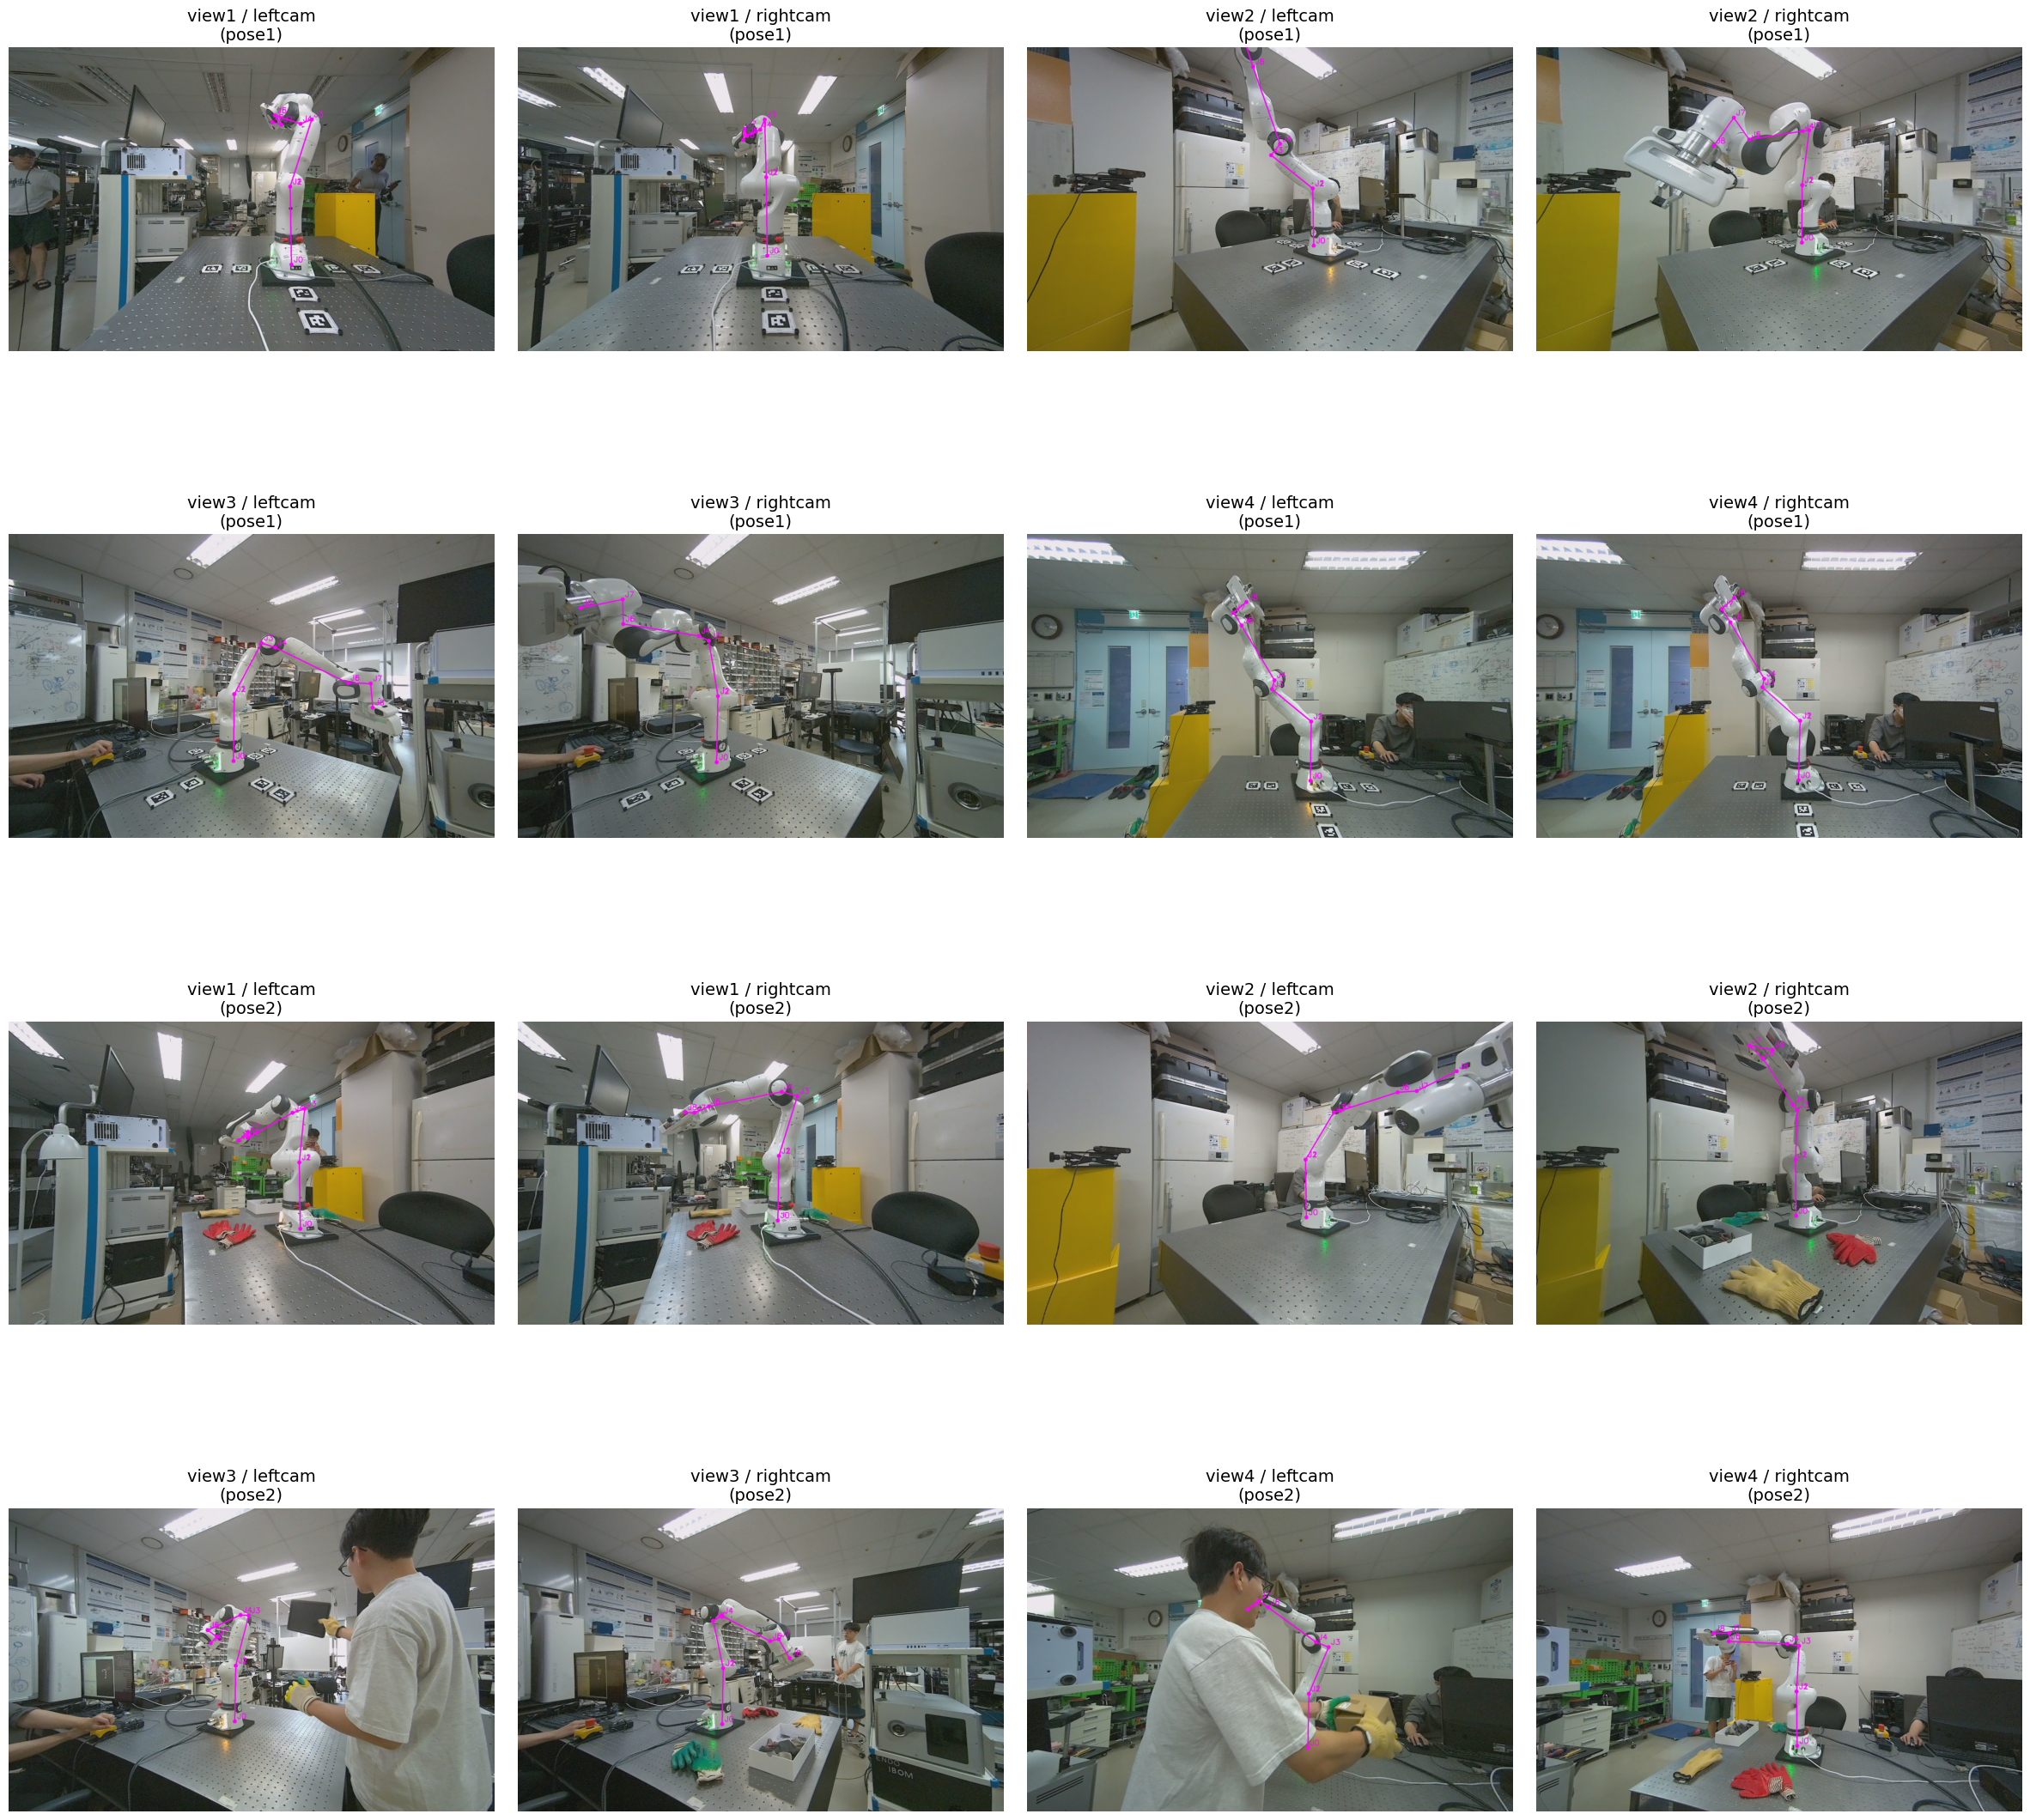

In [50]:
import os
import cv2
import json
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import traceback # ✨ ADDED: For detailed error reporting

# Note: Korean font setup removed as we are now using English for plot titles.

# ---------------------- Helper Functions ----------------------
# (Helper functions are the same as before, so they are omitted for brevity)
# ...
def get_dh_matrix(a, d, alpha, theta):
    """Calculates the transformation matrix from DH parameters."""
    alpha_rad = math.radians(alpha)
    theta_rad = math.radians(theta) # Assumes theta is input in degrees
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad) * np.cos(alpha_rad),  np.sin(theta_rad) * np.sin(alpha_rad), a * np.cos(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad) * np.cos(alpha_rad), -np.cos(theta_rad) * np.sin(alpha_rad), a * np.sin(theta_rad)],
        [0, np.sin(alpha_rad), np.cos(alpha_rad), d],
        [0, 0, 0, 1]
    ])

def get_modified_dh_matrix(a, d, alpha, theta):
    """Craig식 Modified DH: T = Rx(alpha) @ Tx(a) @ Rz(theta) @ Tz(d)"""
    alpha_rad = math.radians(alpha)
    theta_rad = math.radians(theta)

    Rx = np.array([
        [1, 0, 0, 0],
        [0, np.cos(alpha_rad), -np.sin(alpha_rad), 0],
        [0, np.sin(alpha_rad),  np.cos(alpha_rad), 0],
        [0, 0, 0, 1]
    ])
    Tx = np.array([
        [1, 0, 0, a],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    Rz = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad), 0, 0],
        [np.sin(theta_rad),  np.cos(theta_rad), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    Tz = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, d],
        [0, 0, 0, 1]
    ])
    return Rx @ Tx @ Rz @ Tz

def angle_to_joint_coordinate(joint_angles, selected_view):
    """Converts 7 joint angles to 3D coordinates using forward kinematics."""
    # DH Parameters for Franka Research 3 (FR3) robot (meters and degrees)
    # IMPORTANT: Verify these parameters match your robot.
    fr3_dh_parameters = [
        {'a': 0,      'd': 0.333, 'alpha':   0, 'theta_offset': 0}, #1
        {'a': 0,      'd': 0,     'alpha': -90, 'theta_offset': 0}, #2
        {'a': 0,      'd': 0.316, 'alpha':  90, 'theta_offset': 0}, #3
        {'a': 0.0825,  'd': 0,     'alpha':  90, 'theta_offset': 0}, #4
        {'a': -0.0825, 'd': 0.384, 'alpha': -90, 'theta_offset': 0}, #5
        {'a': 0,      'd': 0,     'alpha':  90, 'theta_offset': 0}, #6
        {'a': 0.088,  'd': 0,     'alpha':  90, 'theta_offset': 0}, #7 
        {'a': 0,      'd': 0.107, 'alpha':   0, 'theta_offset': 0}  # flanger
    ]
    
    # Rotational correction for the robot base depending on the camera view
    view_rotations = {
        'view1': R.from_euler('zyx', [90, 180, 0], degrees=True), # Front (reference)
        'view4': R.from_euler('zyx', [90, 180, 0], degrees=True), # Top
        'view3': R.from_euler('zyx', [90, 180, 0], degrees=True), # Left
        'view2': R.from_euler('zyx', [90, 180, 0], degrees=True)  # Right
    }
    
    T_base_correction = np.eye(4)
    if selected_view in view_rotations:
        T_base_correction[:3, :3] = view_rotations[selected_view].as_matrix()

    T_cumulative = T_base_correction
    joint_coords_3d = [np.array([0, 0, 0])] # J0 (base) position
    
    base_point = np.array([[0], [0], [0], [1]])
    for i, angle_rad in enumerate(joint_angles):
        params = fr3_dh_parameters[i]
        theta_deg = math.degrees(angle_rad) + params['theta_offset']
        
        T_i = get_modified_dh_matrix(params['a'], params['d'], params['alpha'], theta_deg)
        T_cumulative = T_cumulative @ T_i
        
        joint_pos = T_cumulative @ base_point
        joint_coords_3d.append(joint_pos[:3, 0])
        
    return np.array(joint_coords_3d, dtype=np.float32)

def project_to_pixel(coords_3d, aruco_result, camera_matrix, dist_coeffs):
    """Projects 3D coordinates onto the 2D image plane."""
    Rvec = np.array([
        aruco_result['rvec_x'],
        aruco_result['rvec_y'],
        aruco_result['rvec_z']
    ], dtype=np.float32)
    Tvec = np.array([
        aruco_result['tvec_x'],
        aruco_result['tvec_y'],
        aruco_result['tvec_z']
    ], dtype=np.float32).reshape(3, 1)

    pixel_coords, _ = cv2.projectPoints(
        coords_3d, Rvec, Tvec, camera_matrix, dist_coeffs
    )
    return pixel_coords.reshape(-1, 2)

def visualize_single_image(ax, image_path, joint_angles, aruco_result, calib_data):
    """Draws the image and projected joints onto a single subplot axis."""
    image = cv2.imread(image_path)
    if image is None:
        ax.set_title(f"Image not found:\n{os.path.basename(image_path)}", color='red')
        ax.axis("off")
        return
        
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    camera_matrix = np.array(calib_data["camera_matrix"], dtype=np.float32)
    dist_coeffs = np.array(calib_data["distortion_coeffs"], dtype=np.float32)
    
    undistorted_img = cv2.undistort(image_rgb, camera_matrix, dist_coeffs)

    view_name = aruco_result['view']
    joint_coords_3d = angle_to_joint_coordinate(joint_angles, view_name)
    pixel_coords = project_to_pixel(joint_coords_3d, aruco_result, camera_matrix, np.zeros_like(dist_coeffs))

    font = cv2.FONT_HERSHEY_SIMPLEX
    for idx, (x, y) in enumerate(pixel_coords.astype(int)):
        cv2.circle(undistorted_img, (x, y), 8, (255, 0, 255), -1) # Magenta
        cv2.putText(undistorted_img, f"J{idx}", (x + 10, y - 10), font, 1.0, (255, 0, 255), 2)
        
        if idx > 0:
            prev_x, prev_y = pixel_coords[idx-1].astype(int)
            cv2.line(undistorted_img, (prev_x, prev_y), (x, y), (255, 0, 255), 3)

    pose_name = "pose1" if "pose1" in image_path else "pose2"
    ax.imshow(undistorted_img)
    ax.axis("off")
    ax.set_title(f"{aruco_result['view']} / {aruco_result['cam']}\n({pose_name})", fontsize=14)

# ---------------------- 🚀 Main Execution ----------------------
# 1. Configure paths
SYNC_CSV_PATH = "../dataset/franka_research3/fr3_matched_joint_angle.csv"
POSE1_ARUCO_JSON_PATH = "../dataset/franka_research3/pose1_aruco_pose_summary.json"
POSE2_ARUCO_JSON_PATH = "../dataset/franka_research3/pose2_aruco_pose_summary.json"
CALIB_DIR = "../dataset/franka_research3/Calib_cam_from_conf"

serial_to_view = {
    '41182735': "view1", '49429257': "view2",
    '44377151': "view3", '49045152': "view4"
}

# 2. Load data
try:
    df_sync = pd.read_csv(SYNC_CSV_PATH)
    with open(POSE1_ARUCO_JSON_PATH, 'r') as f:
        pose1_aruco_results = json.load(f)
    with open(POSE2_ARUCO_JSON_PATH, 'r') as f:
        pose2_aruco_results = json.load(f)
except FileNotFoundError as e:
    print(f"❌ Error: A required file was not found - {e}")
    exit()

print("\n--- [DEBUG] Checking CSV Columns ---")
print(f"Columns found in '{SYNC_CSV_PATH}':")
print(df_sync.columns.tolist())
print("-------------------------------------\n")


# --- 수정된 부분 ---
# 3. Find a RANDOM representative image for each POSE/view/cam combination
poses_to_plot = ['pose1', 'pose2']
views_to_plot = ['view1', 'view2', 'view3', 'view4']
cams_to_plot = ['left', 'right']
selected_data = []

print("--- Finding a random representative image for each POSE/view/cam combination ---")
for pose in poses_to_plot:
    print(f"Searching for pose: '{pose}'")
    for view in views_to_plot:
        for cam in cams_to_plot:
            # Step 1: Find all matching rows for the current combination
            matching_rows = []
            for _, row in df_sync.iterrows():
                image_path = row['image_path']
                if pose not in image_path:
                    continue
                
                try:
                    img_name = os.path.basename(image_path)
                    parts = img_name.split('_')
                    row_view = serial_to_view[parts[1]]
                    row_cam = parts[2]
                    
                    if row_view == view and row_cam == cam:
                        matching_rows.append(row)
                except (KeyError, IndexError):
                    continue

            # Step 2: If matches were found, pick one at random
            if matching_rows:
                selected_row = random.choice(matching_rows)
                selected_data.append(selected_row)
                img_name = os.path.basename(selected_row['image_path'])
                print(f"  ✅ Found {len(matching_rows)} matches for [{pose}/{view}/{cam}]. Randomly selected: {img_name}")
            else:
                print(f"  ⚠️ Could not find any matching image for [{pose}/{view}/{cam}] in the CSV.")


# 4. Create a 4x4 subplot grid and run visualization
if selected_data:
    fig, axes = plt.subplots(4, 4, figsize=(24, 24))
    axes = axes.flatten()

    for i, row in enumerate(selected_data):
        if i >= len(axes):
            break
            
        image_path = row['image_path']
        
        joint_angles = [row[f'position_fr3_joint{j}'] for j in range(1, 8)]
        finger_angles = [row.get(f'position_fr3_finger_joint1', 0.0)] 
        joint_angles.extend(finger_angles)
        
        img_name = os.path.basename(image_path)
        parts = img_name.split('_')
        serial_str = parts[1]
        cam_str = parts[2]
        view_str = serial_to_view[serial_str]
        
        current_aruco_data = None
        pose_name = ""
        if 'pose1' in image_path:
            current_aruco_data = pose1_aruco_results
            pose_name = "pose1"
        elif 'pose2' in image_path:
            current_aruco_data = pose2_aruco_results
            pose_name = "pose2"
        else:
            axes[i].set_title(f"[{view_str}/{cam_str}]\nPose info missing in path", color='orange')
            axes[i].axis("off")
            continue
        
        try:
            aruco_result = next(item for item in current_aruco_data if item['view'] == view_str and item['cam'] == (cam_str + 'cam'))
            calib_path = os.path.join(CALIB_DIR, f"{view_str}_{serial_str}_{cam_str + 'cam'}_calib.json")
            
            with open(calib_path, 'r') as f:
                calib_data = json.load(f)
                
            visualize_single_image(axes[i], image_path, joint_angles, aruco_result, calib_data)

        except StopIteration:
            axes[i].set_title(f"[{view_str}/{cam_str}]\nArUco Data Not Found for {pose_name}", color='red')
            axes[i].axis("off")
        except FileNotFoundError:
            axes[i].set_title(f"[{view_str}/{cam_str}]\nCalib File Not Found", color='red')
            axes[i].axis("off")
        except Exception as e:
            print(f"\n❌ An unexpected error occurred while processing {image_path}:")
            print(f"   Error Type: {type(e).__name__}")
            print(f"   Error Details: {e}")
            traceback.print_exc()
            axes[i].set_title(f"[{view_str}/{cam_str}]\nERROR", color='purple')
            axes[i].axis("off")

    for j in range(len(selected_data), len(axes)):
        axes[j].axis("off")

    plt.tight_layout(pad=2.0)
    plt.show()
else:
    print("\n❌ No data was selected for visualization. Please check your CSV file and paths.")